#### Library

In [1]:
import pandas as pd
# Set pandas options to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

from xgboost import XGBRegressor
import sklearn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf
# from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.preprocessing import StandardScaler


2025-02-18 23:08:55.031637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739945335.058670   19097 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739945335.067630   19097 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-18 23:08:55.094911: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Data Loading

In [2]:
df2021 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2021/merged_df_2021_cleaned.csv')
df2022 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2022/merged_df_2022_cleaned.csv')
df2023 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2023/merged_df_2023_cleaned.csv')
df2024 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2024/merged_df_2024_cleaned.csv')

In [3]:
df = pd.concat([df2021, df2022, df2023, df2024], axis=0, ignore_index=True)

In [4]:
df.shape

(35076, 67)

In [5]:
df.head()

,datetime_,alberta_internal_load,forecast_alberta_internal_load,pool_price,forecast_pool_price,rolling_30day_avg_price,solar_generation,temp_calgary,temp_edmonton,temp_fortmc,wind_generation,ws_calgary,ws_edmonton,ws_fortmc,hour_of_day,day_of_week,week_of_month,month,is_winter,pool_price_lag_1,pool_price_lag_2,pool_price_lag_3,pool_price_lag_4,pool_price_lag_5,pool_price_lag_6,pool_price_lag_7,pool_price_lag_8,pool_price_lag_9,pool_price_lag_10,pool_price_lag_11,pool_price_lag_12,pool_price_lag_13,pool_price_lag_14,pool_price_lag_15,pool_price_lag_16,pool_price_lag_17,pool_price_lag_18,pool_price_lag_19,pool_price_lag_20,pool_price_lag_21,pool_price_lag_22,pool_price_lag_23,pool_price_lag_24,alberta_internal_load_lag_1,alberta_internal_load_lag_2,alberta_internal_load_lag_3,alberta_internal_load_lag_4,alberta_internal_load_lag_5,alberta_internal_load_lag_6,alberta_internal_load_lag_7,alberta_internal_load_lag_8,alberta_internal_load_lag_9,alberta_internal_load_lag_10,alberta_internal_load_lag_11,alberta_internal_load_lag_12,alberta_internal_load_lag_13,alberta_internal_load_lag_14,alberta_internal_load_lag_15,alberta_internal_load_lag_16,alberta_internal_load_lag_17,alberta_internal_load_lag_18,alberta_internal_load_lag_19,alberta_internal_load_lag_20,alberta_internal_load_lag_21,alberta_internal_load_lag_22,alberta_internal_load_lag_23,alberta_internal_load_lag_24
0,2021-01-01 00:00:00,9655.0,9718.0,29.92,32.91,38.45,0.0,-3.2,-5.8,-8.9,1470.686241,13.0,13.0,10.0,0,4,53,1,1,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0
1,2021-01-01 01:00:00,9513.0,9573.0,27.48,27.10,38.44,0.0,2.5,-7.8,-8.6,1525.467843,30.0,13.0,10.0,1,4,53,1,1,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0
2,2021-01-01 02:00:00,9437.0,9446.0,28.62,27.13,38.44,0.0,2.0,-10.4,-8.5,1535.146498,23.0,9.0,10.0,2,4,53,1,1,27.48,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,9513.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0
3,2021-01-01 03:00:00,9376.0,9366.0,33.55,32.14,38.43,0.0,2.4,-11.9,-8.5,1484.051400,24.0,4.0,10.0,3,4,53,1,1,28.62,27.48,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,9437.0,9513.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0
4,2021-01-01 04:00:00,9356.0,9357.0,35.36,35.64,38.43,0.0,2.4,-9.6,-8.9,1446.955595,22.0,4.0,10.0,4,4,53,1,1,33.55,28.62,27.48,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,9376.0,9437.0,9513.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0


In [6]:
# Check for missing values
df.isnull( ).sum().sort_values(ascending=False)

datetime_                         0
alberta_internal_load_lag_8       0
pool_price_lag_18                 0
pool_price_lag_19                 0
pool_price_lag_20                 0
pool_price_lag_21                 0
pool_price_lag_22                 0
pool_price_lag_23                 0
pool_price_lag_24                 0
alberta_internal_load_lag_1       0
alberta_internal_load_lag_2       0
alberta_internal_load_lag_3       0
alberta_internal_load_lag_4       0
alberta_internal_load_lag_5       0
alberta_internal_load_lag_6       0
alberta_internal_load_lag_7       0
alberta_internal_load_lag_9       0
pool_price_lag_16                 0
alberta_internal_load_lag_10      0
alberta_internal_load_lag_11      0
alberta_internal_load_lag_12      0
alberta_internal_load_lag_13      0
alberta_internal_load_lag_14      0
alberta_internal_load_lag_15      0
alberta_internal_load_lag_16      0
alberta_internal_load_lag_17      0
alberta_internal_load_lag_18      0
alberta_internal_load_lag_19

In [7]:
df.head()

,datetime_,alberta_internal_load,forecast_alberta_internal_load,pool_price,forecast_pool_price,rolling_30day_avg_price,solar_generation,temp_calgary,temp_edmonton,temp_fortmc,wind_generation,ws_calgary,ws_edmonton,ws_fortmc,hour_of_day,day_of_week,week_of_month,month,is_winter,pool_price_lag_1,pool_price_lag_2,pool_price_lag_3,pool_price_lag_4,pool_price_lag_5,pool_price_lag_6,pool_price_lag_7,pool_price_lag_8,pool_price_lag_9,pool_price_lag_10,pool_price_lag_11,pool_price_lag_12,pool_price_lag_13,pool_price_lag_14,pool_price_lag_15,pool_price_lag_16,pool_price_lag_17,pool_price_lag_18,pool_price_lag_19,pool_price_lag_20,pool_price_lag_21,pool_price_lag_22,pool_price_lag_23,pool_price_lag_24,alberta_internal_load_lag_1,alberta_internal_load_lag_2,alberta_internal_load_lag_3,alberta_internal_load_lag_4,alberta_internal_load_lag_5,alberta_internal_load_lag_6,alberta_internal_load_lag_7,alberta_internal_load_lag_8,alberta_internal_load_lag_9,alberta_internal_load_lag_10,alberta_internal_load_lag_11,alberta_internal_load_lag_12,alberta_internal_load_lag_13,alberta_internal_load_lag_14,alberta_internal_load_lag_15,alberta_internal_load_lag_16,alberta_internal_load_lag_17,alberta_internal_load_lag_18,alberta_internal_load_lag_19,alberta_internal_load_lag_20,alberta_internal_load_lag_21,alberta_internal_load_lag_22,alberta_internal_load_lag_23,alberta_internal_load_lag_24
0,2021-01-01 00:00:00,9655.0,9718.0,29.92,32.91,38.45,0.0,-3.2,-5.8,-8.9,1470.686241,13.0,13.0,10.0,0,4,53,1,1,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0
1,2021-01-01 01:00:00,9513.0,9573.0,27.48,27.10,38.44,0.0,2.5,-7.8,-8.6,1525.467843,30.0,13.0,10.0,1,4,53,1,1,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0
2,2021-01-01 02:00:00,9437.0,9446.0,28.62,27.13,38.44,0.0,2.0,-10.4,-8.5,1535.146498,23.0,9.0,10.0,2,4,53,1,1,27.48,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,9513.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0
3,2021-01-01 03:00:00,9376.0,9366.0,33.55,32.14,38.43,0.0,2.4,-11.9,-8.5,1484.051400,24.0,4.0,10.0,3,4,53,1,1,28.62,27.48,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,9437.0,9513.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0
4,2021-01-01 04:00:00,9356.0,9357.0,35.36,35.64,38.43,0.0,2.4,-9.6,-8.9,1446.955595,22.0,4.0,10.0,4,4,53,1,1,33.55,28.62,27.48,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,9376.0,9437.0,9513.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0


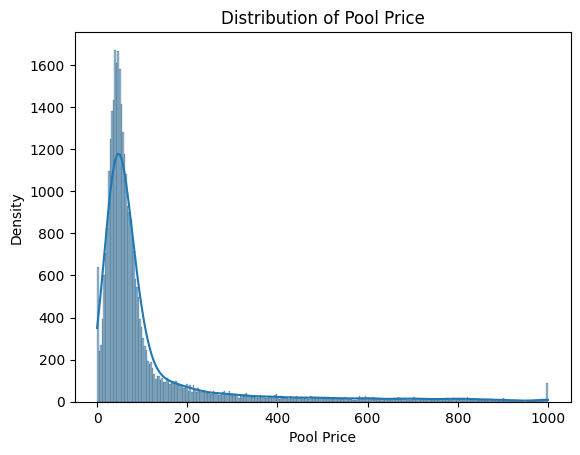

In [8]:
# Create a distribution plot of the 'pool_price' column
sns.histplot(df['pool_price'], kde=True)

# Add labels and title
plt.xlabel('Pool Price')
plt.ylabel('Density')
plt.title('Distribution of Pool Price')

# Show the plot
plt.show()

In [9]:
# data filter
df = df[df['pool_price'] <=200]

#### Train-Test split

In [10]:
# Convert datetime_ column to datetime type
df['datetime_'] = pd.to_datetime(df['datetime_'])

# Filter data for the first 11 months
train_data = df[df['datetime_'] < '2024-07-01']
test_data = df[df['datetime_'] >= '2024-07-01']

# Define independent variables (features) and target variable
X_train = train_data.drop(columns=['datetime_', 'pool_price'])
y_train = train_data['pool_price']
# Display the shapes of the training data
print(X_train.shape, y_train.shape)

# Define independent variables (features) and target variable
X_test = test_data.drop(columns=['datetime_', 'pool_price'])
y_test = test_data['pool_price']
# Display the shapes of the training data
print(X_test.shape, y_test.shape)

(26300, 65) (26300,)
(4203, 65) (4203,)


In [11]:
#Converting dataframe to numpy

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [12]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
#Reshaping the train and test data to pass into the LSTM layer

X_train = X_train.reshape((X_train.shape[0], 1, int(X_train.shape[1])))
X_test = X_test.reshape((X_test.shape[0], 1, int(X_test.shape[1])))

In [14]:
# Display the shapes of the training data
X_train.shape

(26300, 1, 65)

#### Model Training

In [15]:
#Baseline LSTM model

model = tf.keras.Sequential()
model.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]))) #return_sequences=True,
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mae')

2025-02-18 23:09:02.197900: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/kevin/Downloads/BESS/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
# display architecture of model shape of different layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        99,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,697 (428.50 KB)

 Trainable params: 109,697 (428.50 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Fit the model
history = model.fit(X_train, y_train, epochs=20, batch_size=128, verbose=2, validation_split=0.2)

Epoch 1/20
165/165 - 5s - 32ms/step - loss: 36.2695 - val_loss: 17.1667
Epoch 2/20
165/165 - 1s - 6ms/step - loss: 16.2810 - val_loss: 13.2765
Epoch 3/20
165/165 - 1s - 7ms/step - loss: 13.6671 - val_loss: 13.0126
Epoch 4/20
165/165 - 1s - 6ms/step - loss: 11.8140 - val_loss: 12.9743
Epoch 5/20
165/165 - 1s - 6ms/step - loss: 10.5043 - val_loss: 11.3231
Epoch 6/20
165/165 - 1s - 7ms/step - loss: 9.8055 - val_loss: 10.9700
Epoch 7/20
165/165 - 1s - 6ms/step - loss: 9.4424 - val_loss: 10.7536
Epoch 8/20
165/165 - 1s - 6ms/step - loss: 9.1601 - val_loss: 11.0912
Epoch 9/20
165/165 - 1s - 6ms/step - loss: 8.9913 - val_loss: 10.3063
Epoch 10/20
165/165 - 1s - 6ms/step - loss: 8.7754 - val_loss: 10.4013
Epoch 11/20
165/165 - 1s - 6ms/step - loss: 8.6973 - val_loss: 9.9422
Epoch 12/20
165/165 - 1s - 6ms/step - loss: 8.6225 - val_loss: 9.8169
Epoch 13/20
165/165 - 1s - 6ms/step - loss: 8.4885 - val_loss: 9.6783
Epoch 14/20
165/165 - 1s - 8ms/step - loss: 8.4615 - val_loss: 10.0014
Epoch 15/20


#### Model Performance Check

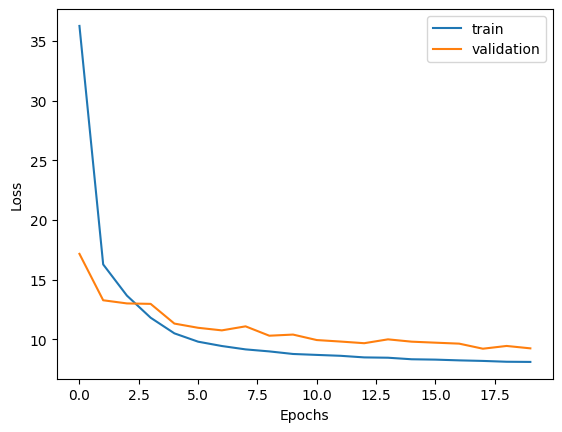

In [18]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
y_train_pred = model.predict(X_train)
y_train_pred = y_train_pred.reshape(-1, 1)
mae = mean_absolute_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print('y_train shape:', y_train.shape)
print(f'Mean Absolute Error on the train set : {mae}')
print(f"R² Score train set: {r2}")

822/822 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
y_train shape: (26300,)
Mean Absolute Error on the train set : 8.13920130016994
R² Score train set: 0.7949416694706721


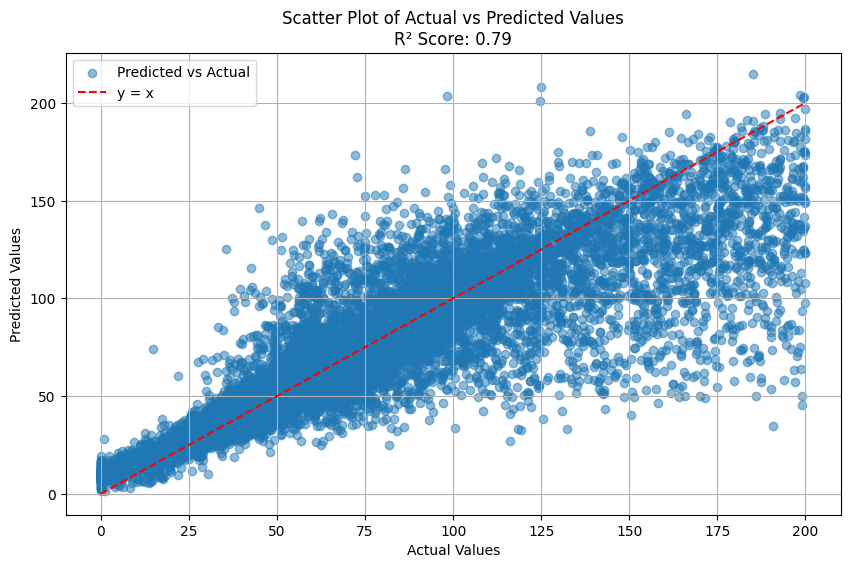

In [20]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred, alpha=0.5, label='Predicted vs Actual')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--', label='y = x')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Scatter Plot of Actual vs Predicted Values\nR² Score: {r2:.2f}')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
y_test_pred = model.predict(X_test)
y_test_pred = y_test_pred.reshape(-1, 1)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print('y_test_pred shape:', y_test_pred.shape)
print(f'Mean Absolute Error on the test set : {mae}')
print(f"R² Score test set: {r2}")

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
y_test_pred shape: (4203, 1)
Mean Absolute Error on the test set : 9.260362322462646
R² Score test set: 0.7423115153602735


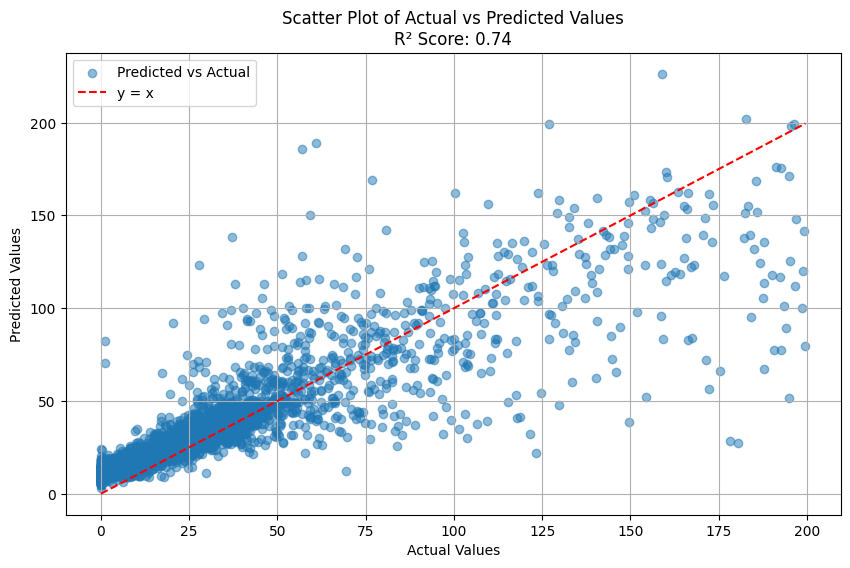

In [22]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='y = x')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Scatter Plot of Actual vs Predicted Values\nR² Score: {r2:.2f}')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# Create a dataframe of the actual and predicted values
results_df = pd.DataFrame({'y_test':y_test, 'y_test_pred':y_test_pred.flatten()})
results_df.head()

,y_test,y_test_pred
0,14.69,22.390833
1,16.23,21.782997
2,15.77,20.696463
3,13.85,18.518068
4,13.58,18.958685


In [24]:
terget_df = results_df[results_df['y_test'] <= 200]

mae = mean_absolute_error(terget_df.y_test, terget_df.y_test_pred)
r2 = r2_score(terget_df.y_test, terget_df.y_test_pred)

print('terget_df shape:', terget_df.shape)
print(f'Mean Absolute Error on the test set : {mae}')
print(f"R² Score test set: {r2}")

terget_df shape: (4203, 2)
Mean Absolute Error on the test set : 9.260362322462646
R² Score test set: 0.7423115153602735


In [25]:
terget_df = results_df[results_df['y_test'] > 200]

mae = mean_absolute_error(terget_df.y_test, terget_df.y_test_pred)
r2 = r2_score(terget_df.y_test, terget_df.y_test_pred)

print('terget_df shape:', terget_df.shape)
print(f'Mean Absolute Error on the test set : {mae}')
print(f"R² Score test set: {r2}")

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.